# Waves Simulation Notebook 16

This final Notebook presents the solution of a 2D elastic wave equation using the finite-difference approach.

## Numerical Simulations

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
def lame_parameters(vp,vs,rho):
    M = vs*vs*rho
    L = vp*vp*rho - 2*M
    return L,M

In [3]:
def build_ricker(time,freq):
    ricker = np.zeros(len(time))
    t0     = 1.4*np.sqrt(6)/(np.pi*freq)
    a2     = (np.pi*freq*(time-t0))**2
    ricker = (1.-2.*a2)*np.exp(-a2)
    return ricker


In [4]:
def build_gaussian(time,freq,alpha):
    gaussian = np.zeros(len(time))
    t0     = np.sqrt(6)/(np.pi*freq)
    gaussian = np.exp(-alpha*(time-t0)**2)
    return gaussian

In [5]:
def build_derivate_gaussian(time,freq,alpha):
    der_gauss = np.zeros(len(time))
    t0     = np.sqrt(6)/(np.pi*freq)
    der_gauss =  (-2*alpha*(time-t0)**2) * (np.exp(-alpha*(time-t0)**2))
    return der_gauss

In [6]:
def fdtd(vp,vs,rho,nx,nz,nt,source1,sx,sz,dx,dt):
    B = 1/rho
    L,M = lame_parameters(vp,vs,rho)  

    #initial conditions for velocity
    U = np.zeros([nz,nx,nt])
    V  = np.zeros([nz,nx,nt])
    
    #initial conditions for stress
    Sigma = np.zeros([nz,nx,nt])
    T     = np.zeros([nz,nx,nt])
    Ksi   = np.zeros([nz,nx,nt])
    
    for it in range(1,len(source1)):
        # Displacement 
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                U[iz,ix,it] =   U[iz,ix,it-1] + (B*dt/dx) * (Sigma[iz,ix,it-1] - Sigma[iz,ix-1,it-1]) + (B*dt/dz) * (Ksi[iz,ix,it-1] - Ksi[iz-1,ix,it-1])    
  
        
        for iz in range(1,nx-1):
            for ix in range(1,nz-1): 
                V[iz,ix,it] =   V[iz,ix,it-1] + (B*dt/dx) *  (Ksi[iz,ix+1,it-1]   - Ksi[iz,ix,it-1]) +  (B*dt/dz) * (T[iz+1,ix,it-1] - T[iz,ix,it-1])        
                
        # Stress 
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                Sigma[iz,ix,it] = Sigma[iz,ix,it-1] + (L+2*M) * (dt/dx) * (U[iz,ix+1,it] - U[iz,ix,it]) +  L * (dt/dz) * (V[iz,ix,it] -  V[iz-1,ix,it])     
        Sigma[sz,sx,it] =  Sigma[sz,sx,it] +  source1[it]/(dx*dx*dt)
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                T[iz,ix,it] = T[iz,ix,it-1] + (L+2*M) * (dt/dz) * (V[iz,ix,it] - V[iz-1,ix,it]) +  L * (dt/dx) * (U[iz,ix+1,it] -  U[iz,ix,it])      
        T[sz,sx,it] =  T[sz,sx,it] +  source1[it]/(dx*dx*dt)
        for iz in range(1,nx-1):
            for ix in range(1,nz-1):
                Ksi[iz,ix,it] = Ksi[iz,ix,it-1] + (M) * (dt/dz) * (U[iz+1,ix,it] - U[iz,ix,it]) +  M * (dt/dx) * (V[iz,ix,it] -  V[iz,ix-1,it])    

    return Sigma,T,Ksi,U,V

In [7]:
#Parameters Setup
# ---------------------------------------
vp   = 8             # P waves velocity
vs   = int(vp/np.sqrt(3))   # S waves velocity
freq = 5                    
rho  = 2500/1e9   # density
lx = 4                    
lz = 4                    
dx = vs/(freq*20)    
dz = dx
nx = int(np.floor(lx/dx+1))
nz = int(np.floor(lz/dx+1))

#Source Parameters
# ---------------------------------------
T_record =  1                        
stab_condition = dx/(vp)
dt       =  stab_condition/np.sqrt(2)   
time     =  np.arange(0,T_record,dt)
nt       =  len(time)

# Sources
# ---------------------------------------
gaussian  =  build_gaussian(time,freq,alpha=200)            
der_gauss =  build_derivate_gaussian(time,freq,alpha=40)    
ricker    =  build_ricker(time,freq)
sx = 31                    
sz = 31                   

In [8]:
# Finite Difference Method
# ---------------------------------------

Sigma,T,Ksi,U,V = fdtd(vp,vs,rho,nx,nz,nt,ricker,sx,sz,dx,dt)

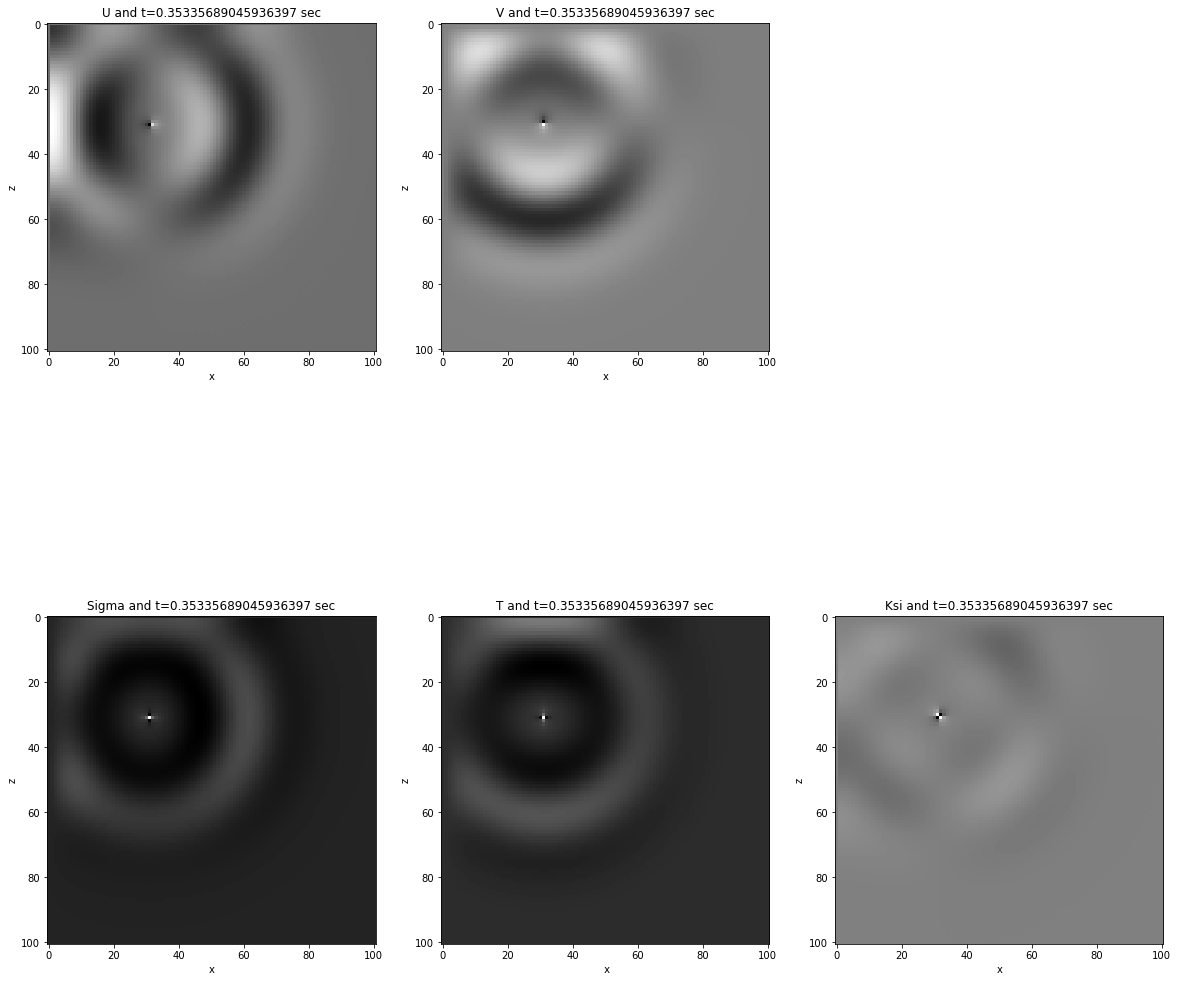

In [9]:
# Results
# ---------------------------------------


t=100      
timing = t*T_record/T.shape[2]
fig = plt.figure(figsize=(20,20))

axis1 = fig.add_subplot(231)
axis1.set_ylabel('z')
axis1.set_xlabel('x')
axis1.set_title("U and t=%s sec"%timing)
axis1.imshow(U[:,:,t],cmap='gray')

axis2 = fig.add_subplot(232)
axis2.set_ylabel('z')
axis2.set_xlabel('x')
axis2.set_title("V and t=%s sec"%timing)
axis2.imshow(V[:,:,t],cmap='gray')

axis3 = fig.add_subplot(234)
axis3.set_ylabel('z')
axis3.set_xlabel('x')
axis3.set_title("Sigma and t=%s sec"%timing)
axis3.imshow(Sigma[:,:,t],cmap='gray')

axis4 = fig.add_subplot(235)
axis4.set_ylabel('z')
axis4.set_xlabel(' x')
axis4.set_title("T and t=%s sec"%timing)
axis4.imshow(T[:,:,t],cmap='gray')

axis5 = fig.add_subplot(236)
axis5.set_ylabel('z')
axis5.set_xlabel('x')
axis5.set_title("Ksi and t=%s sec"%timing)
axis5.imshow(Ksi[:,:,t],cmap='gray')


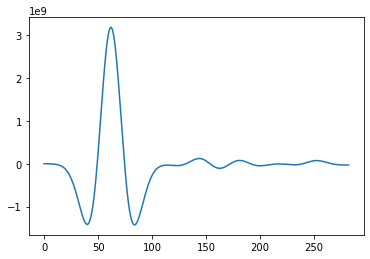

In [10]:
#Seismogram
# ---------------------------------------

lambda_sz = sz
lambda_sx = sx
src_model = U[lambda_sz,lambda_sx,:]
plt.plot(src_model)